<a href="https://colab.research.google.com/github/anushavasup/object_detection_Dove/blob/main/DoveDetection_anu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_inception_v2': {
        'model_name': 'ssd_inception_v2_coco_2017_11_17',
        'pipeline_file': 'ssd_inception_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    }
}
selected_model = 'ssd_inception_v2'

In [2]:
#!pip install lxml tk cython contextlib2 pillow matplotlib pycocotools
!pip install lxml cython contextlib2 pillow matplotlib pycocotools

In [3]:
!pip install protobuf

In [4]:
!apt-get install -qq protobuf-compiler 

In [5]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5 MB 8.4 kB/s 
     |████████████████████████████████| 3.8 MB 25.0 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 503 kB 37.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c67d27a557a79e539893170770fcb2445143fc6823476f7130509423b0afa7af
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

In [6]:





import tensorflow as tf
print(tf.__version__)

1.15.0


In [7]:
#from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import csv
import re
import cv2 
import os
import glob
import xml.etree.ElementTree as ET
import io
import tensorflow.compat.v1 as tf
from PIL import Image
from collections import namedtuple, OrderedDict
import shutil
import urllib.request
import tarfile

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp -r "/content/drive/My Drive/annot.zip" "Bird"

In [10]:
!unzip Bird

Archive:  Bird
  inflating: Test/24.jpg             
  inflating: Test/25.jpg             
  inflating: Test/26.jpg             
  inflating: Test/27.jpg             
  inflating: Test/28.jpg             
  inflating: Test/29.jpg             
  inflating: Test/30.jpg             
  inflating: Test/31.jpg             
  inflating: Test/32.jpg             
  inflating: Test/33.jpg             
  inflating: Test/34.jpg             
  inflating: Test/35.jpg             
  inflating: Test/36.jpg             
  inflating: Test/65.jpg             
  inflating: Test/66.jpg             
  inflating: Test/67.jpg             
  inflating: Test/68.jpg             
  inflating: Test/69.jpg             
  inflating: Test/70.jpg             
  inflating: Test/71.jpg             
  inflating: Test/72.jpg             
  inflating: Test/73.jpg             
  inflating: Test/74.jpg             
  inflating: Test/75.jpg             
  inflating: Test/76.jpg             
  inflating: Test/77.jpg           

In [11]:
ls


Bird  drive/  sample_data/  Test/  Test_ann/  Train/  Train_ann/


In [12]:
os.mkdir('Bird_images')

In [13]:
cd Bird_images/

/content/Bird_images


In [14]:
ls

generate_tfrecord.py  Test/      Train/      xml_to_csv.py
label_map.pbtxt       Test_ann/  Train_ann/


In [15]:


!python xml_to_csv.py -i /content/Bird_images/Train_ann -o /content/Bird_images/Train_ann/Train_labels.csv

Successfully converted xml to csv.


In [16]:
!python xml_to_csv.py -i /content/Bird_images/Test_ann -o /content/Bird_images/Test_ann/Test_labels.csv

Successfully converted xml to csv.


In [17]:
# Downlaods Tenorflow
%cd /content/Bird_images/
!git clone --q https://github.com/tensorflow/models.git

/content/Bird_images


In [18]:
%cd /content/Bird_images/models/research
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.
# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/gun_detection/models/research/:/content/gun_detection/models/research/slim/'

/content/Bird_images/models/research


In [19]:
!pip install tf-slim

     |████████████████████████████████| 352 kB 5.3 MB/s 


In [20]:
#%cd models/research/
#!protoc object_detection/protos/*.proto --python_out=.
%cp object_detection/packages/tf2/setup.py .
!python -m pip install .
#!pip install .

Processing /content/Bird_images/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.8 MB 101 kB/s 
     |████████████████████████████████| 1.8 MB 34.6 MB/s 
     |████████████████████████████████| 636 kB 21.6 MB/s 
     |████████████████████████████████| 211 kB 44.0 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.2 MB 27.1 MB/s 
     |████████████████████████████████| 4.4 MB 41.1 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 1

In [21]:
!python /content/Bird_images/generate_tfrecord.py --label0=Dove --label1=person --csv_input=/content/Bird_images/Train_ann/Train_labels.csv --output_path=/content/Bird_images/Train_ann/train.record --img_path=/content/Bird_images/Train



W0910 14:49:23.608398 140118950541184 module_wrapper.py:139] From /content/Bird_images/generate_tfrecord.py:104: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0910 14:49:23.633570 140118950541184 module_wrapper.py:139] From /content/Bird_images/generate_tfrecord.py:62: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Traceback (most recent call last):
  File "/content/Bird_images/generate_tfrecord.py", line 118, in <module>
    tf.app.run()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/content/Bird_images/generate_tfrecord.py", line 109, in main
    tf_example

In [22]:
!python /content/Bird_images/generate_tfrecord.py --label0=Dove --label1=person --csv_input=/content/Bird_images/Test_ann/Test_labels.csv --output_path=/content/Bird_images/Test_ann/test.record --img_path=/content/Bird_images/Test



W0910 14:49:32.032896 139951213688704 module_wrapper.py:139] From /content/Bird_images/generate_tfrecord.py:104: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0910 14:49:32.045185 139951213688704 module_wrapper.py:139] From /content/Bird_images/generate_tfrecord.py:62: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/Bird_images/Test_ann/test.record


## Downloading the Base Model
1. Based on the model selecting at the top of this notebook, downloading the model selected and extracting its content.
2. Creating a dir to save the model while training.

In [23]:
%cd /content/Bird_images/models/research

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#the distination folder where the model will be saved
fine_tune_dir = '/content/Bird_images/models/research/pretrained_model'

#checks if the model has already been downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the file and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

/content/Bird_images/models/research


In [24]:
#checking the content of the pretrained model.
# this is the directory of the "fine_tune_checkpoint" that is used in the config file.
!echo {fine_tune_dir}
!ls -alh {fine_tune_dir}

/content/Bird_images/models/research/pretrained_model
total 197M
drwxr-x---  3 275875 5000 4.0K Nov 18  2017 .
drwxr-xr-x 23 root   root 4.0K Sep 10 14:49 ..
-rw-r-----  1 275875 5000   77 Nov 18  2017 checkpoint
-rw-r-----  1 275875 5000  98M Nov 18  2017 frozen_inference_graph.pb
-rw-r-----  1 275875 5000  96M Nov 18  2017 model.ckpt.data-00000-of-00001
-rw-r-----  1 275875 5000  18K Nov 18  2017 model.ckpt.index
-rw-r-----  1 275875 5000 3.6M Nov 18  2017 model.ckpt.meta
drwxr-x---  3 275875 5000 4.0K Nov 18  2017 saved_model


## Configuring the Training Pipeline
1. Adding the path for the TFRecords files and pbtxt,batch_size,num_steps,num_classes to the configuration file.
2. Adding some Image augmentation.
3. Creating a directory to save the model at each checkpoint while training. 

In [25]:
#the path to the folder containing all the sample config files
CONFIG_BASE = "/content/Bird_images/models/research/object_detection/samples/configs/"
#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)
model_pipline

'/content/Bird_images/models/research/object_detection/samples/configs/ssd_inception_v2_coco.config'

In [26]:
#check the sample config file that is provided by the tf model
!cat /content/Bird_images/models/research/object_detection/samples/configs/ssd_inception_v2_coco.config

# SSD with Inception v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 90
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

In [27]:
!cat /content/Bird_images/label_map.pbtxt

item {
    id: 1
    name: 'Dove'
}

item {
    id: 2
    name: 'person'
}




In [28]:
#editing the configuration file to add the path for the TFRecords files, pbtxt,batch_size,num_steps,num_classes.
# any image augmentation, hyperparemeter tunning (drop out, batch normalization... etc) would be editted here

%%writefile {model_pipline}

model {
  ssd {
    num_classes: 3
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
        reduce_boxes_in_lowest_layer: true
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 3
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_inception_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
      override_base_feature_extractor_hyperparams: true
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 0
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/content/Bird_images/models/research/pretrained_model/model.ckpt"
  from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 4000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/Bird_images/Train_ann/train.record"
  }
  label_map_path: "/content/Bird_images/label_map.pbtxt"
}

eval_config: {
  num_examples: 20000
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/Bird_images/Test_ann/test.record"
  }
  label_map_path: "/content/Bird_images/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting /content/Bird_images/models/research/object_detection/samples/configs/ssd_inception_v2_coco.config


In [29]:
# where the model will be saved at each checkpoint while training 
model_dir = 'training/'

# Optionally: remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

In [30]:
!pip install -U numpy==1.17.0

     |████████████████████████████████| 20.3 MB 1.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.17.0 which is incompatible.
tensorflow-gpu 1.15.0 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
tensorflow-gpu 1.15.0 requires tensorboard<1.16.0,>=1.15.0, but you have tensorboard 2.6.0 which is incompatible.
tensorflow-gpu 1.15.0 requires tensorflow-estimator==1.15.1, but you have tensorflow-estimator 2.6.0 which is incompatible.
lvis 0.5.3 requires numpy>=1.18.2, but you have numpy 1.17.0 which is incompatible.
kapre 0.3.5 requires numpy>=1.18.5, but you have numpy 1.17.0 which is incompatible.
jaxlib 0.1.70+cuda110 requir

In [31]:
pwd

'/content/Bird_images/models/research'

In [32]:
cd slim

/content/Bird_images/models/research/slim


In [33]:
!python setup.py build

running build
running build_py
creating build
creating build/lib
creating build/lib/deployment
copying deployment/model_deploy.py -> build/lib/deployment
copying deployment/__init__.py -> build/lib/deployment
copying deployment/model_deploy_test.py -> build/lib/deployment
creating build/lib/nets
copying nets/alexnet_test.py -> build/lib/nets
copying nets/resnet_utils.py -> build/lib/nets
copying nets/dcgan_test.py -> build/lib/nets
copying nets/s3dg.py -> build/lib/nets
copying nets/mobilenet_v1_test.py -> build/lib/nets
copying nets/inception_utils.py -> build/lib/nets
copying nets/dcgan.py -> build/lib/nets
copying nets/post_training_quantization.py -> build/lib/nets
copying nets/resnet_v1_test.py -> build/lib/nets
copying nets/lenet.py -> build/lib/nets
copying nets/overfeat_test.py -> build/lib/nets
copying nets/alexnet.py -> build/lib/nets
copying nets/i3d_utils.py -> build/lib/nets
copying nets/i3d_test.py -> build/lib/nets
copying nets/inception_resnet_v2.py -> build/lib/nets
co

In [34]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing slim.egg-info/PKG-INFO
writing dependency_links to slim.egg-info/dependency_links.txt
writing requirements to slim.egg-info/requires.txt
writing top-level names to slim.egg-info/top_level.txt
writing manifest file 'slim.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/deployment
copying build/lib/deployment/model_deploy.py -> build/bdist.linux-x86_64/egg/deployment
copying build/lib/deployment/__init__.py -> build/bdist.linux-x86_64/egg/deployment
copying build/lib/deployment/model_deploy_test.py -> build/bdist.linux-x86_64/egg/deployment
creating build/bdist.linux-x86_64/egg/nets
copying build/lib/nets/alexnet_test.py -> build/bdist.linux-x86_64/egg/nets
copying build/lib/nets/resnet_utils.py -> build/bdist.linux-x86_64/egg/nets
copying build/lib/nets/dc

In [35]:
cd ..

/content/Bird_images/models/research


In [42]:
#import tensorflow.compat.estimator as tf
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0

!python3 /content/Bird_images/models/research/object_detection/model_main.py \
    --pipeline_config_path={model_pipline}\
    --model_dir={model_dir} \
    --alsologtostderr \

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 339 kB 5.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
     |████████████████████████████████| 412.3 MB 19 kB/s 
  Using cached gast-0.2.2-py3-none-any.whl
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation

     |████████████████████████████████| 2.9 MB 5.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


W0910 15:05:13.982210 140188316039040 model_lib.py:817] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I0910 15:05:13.982510 140188316039040 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0910 15:05:13.982688 140188316039040 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0910 15:05:13.982852 140188316039040 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0910 15:05:13.983029 140188316039040 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0910 15:05:13.983270 140188316039040 model_lib.py:833] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

In [43]:
#the location where the exported model will be saved in.
output_directory = '/content/Bird_images/models/research/fine_tuned_model'

# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
!python /content/Bird_images/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-4000
Instructions for updating:
Please use `layer.__call__` method instead.
W0910 16:09:31.497816 140135590356864 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0910 16:09:34.881294 140135590356864 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0910 16:09:34.933896 140135590356864 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0910 16:09:34.983910 140135590356864 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:dept

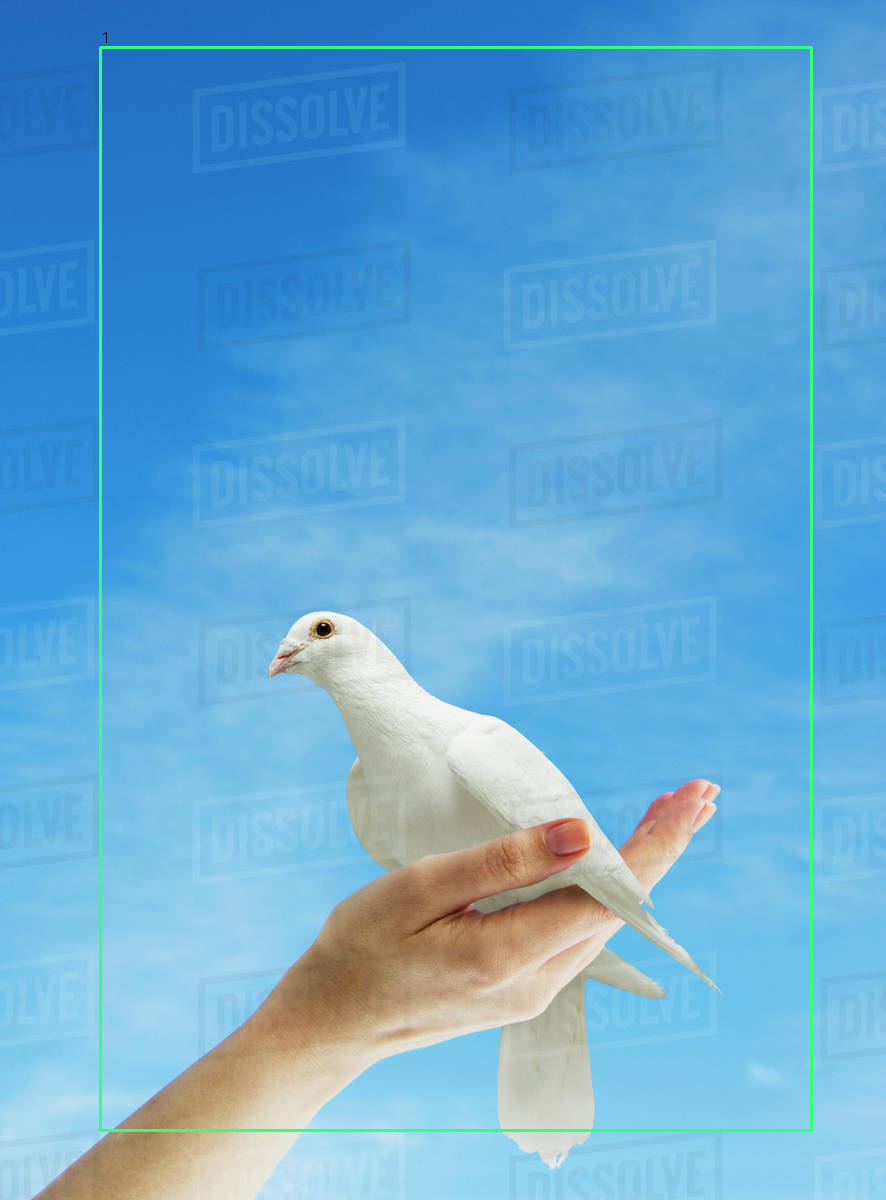

-1

In [46]:
import numpy as np
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow

# Read the graph.
with tf.gfile.FastGFile(output_directory + '/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    # Read and preprocess an image.
    img = cv.imread('/content/Image.jpg')
    rows = img.shape[0]
    cols = img.shape[1]
    inp = cv.resize(img, (300, 300))
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

    # Run the model
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})

    # Visualize detected bounding boxes.
    num_detections = int(out[0][0])
    for i in range(num_detections):
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.3:
            x = bbox[1] * cols
            y = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            cv.rectangle(img, (int(x), int(y)), (int(right), int(bottom)), (125, 255, 51), thickness=2)
            text = "{}".format(classId)
            cv.putText(img,text, (int(x), (int(y)-5)), cv.FONT_HERSHEY_SIMPLEX, 0.5, 2)

cv2_imshow(img)
cv.waitKey()